**Step 1: Mount drive**

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Import required libraries**

In [144]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import (DistilBertTokenizerFast,DistilBertForSequenceClassification,Trainer,TrainingArguments, EarlyStoppingCallback)
from datasets import Dataset, ClassLabel, Features, Value

**Step 3: Data Injestion**

In [145]:
df = pd.read_csv("/content/drive/MyDrive/datasets/Support Tickets.csv")
df.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,Unnamed: 14
0,Problem with Invoice,I am encountering a problem with my invoice. T...,In response to your email about the incorrect ...,Incident,Billing and Payments,low,en,Billing,Technical,Invoice,Payment,Account,Bug,NaN,NaN
1,Invoicing Discrepancy Inquiry,I am contacting you to address a recent billin...,We are examining the overcharge on your most r...,Problem,Billing and Payments,low,en,Billing,Account,Resolution,Inquiry,Discrepancy,Customer,NaN,NaN
2,Issue with Overcharged Subscription Services,There was an overcharge by the marketing agency.,We are looking into the issue of overcharged s...,Problem,Billing and Payments,medium,en,Billing,Refund,Payment,Account,NaN,NaN,NaN,NaN
3,Modify My Profile,I require to update my payment details for my ...,"To update your payment details, please log in ...",Request,Billing and Payments,high,en,Billing,Payment,Account,Guidance,Documentation,NaN,NaN,NaN
4,Misleading Invoices,Incorrect invoices have been issued to clients...,"Dear <name>, we are investigating the discrepa...",Problem,Billing and Payments,medium,en,Billing,Customer,Investigation,Documentation,Feedback,NaN,NaN,NaN


**Step 4: Preliminary Analysis**

In [146]:
# Step 3: Preliminary Analysis
    # - Data Profiling: Summary Statistics, Frequency counts, Data Types
    # - Distribution Analysis: Histograms, boxplots
    # - Correlation Exploration
    # - Identify Duplicates
    # - Missing values percentages and imputation strategies

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject      1599 non-null   object
 1   body         1785 non-null   object
 2   answer       1784 non-null   object
 3   type         1785 non-null   object
 4   queue        1785 non-null   object
 5   priority     1785 non-null   object
 6   language     1785 non-null   object
 7   tag_1        1785 non-null   object
 8   tag_2        1785 non-null   object
 9   tag_3        1780 non-null   object
 10  tag_4        1745 non-null   object
 11  tag_5        1275 non-null   object
 12  tag_6        551 non-null    object
 13  tag_7        251 non-null    object
 14  Unnamed: 14  113 non-null    object
dtypes: object(15)
memory usage: 209.3+ KB


In [148]:
# Check missing values
missing_val_count = df.isna().sum()
missing_val_count = missing_val_count[missing_val_count > 0]
if len(missing_val_count) == 0:
    print("No missing values")
else:
    print("Missing value percentages: \n", missing_val_count)

Missing value percentages: 
 subject         186
answer            1
tag_3             5
tag_4            40
tag_5           510
tag_6          1234
tag_7          1534
Unnamed: 14    1672
dtype: int64


In [149]:
# Checking missing value percentages
missing_val_percentages = (df.isna().sum() / len(df)) * 100
missing_val_percentages = missing_val_percentages[missing_val_percentages>0]
if len(missing_val_percentages) == 0:
    print("No missing values")
else:
    print("Missing value percentages: \n", missing_val_percentages)

Missing value percentages: 
 subject        10.420168
answer          0.056022
tag_3           0.280112
tag_4           2.240896
tag_5          28.571429
tag_6          69.131653
tag_7          85.938375
Unnamed: 14    93.669468
dtype: float64


In [150]:
# Check for duplicates
df.duplicated().any()

np.False_

**Step 5: Data Cleaning & Feature Engineering**

In [151]:
df=df[df['language']=='en']

In [152]:
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
X = df["text"]

**Step 6: Class Imbalance Handling**

Rare labels (< 30 samples) collapsed into "Other"

In [153]:
df['tag_2'].value_counts()

,count
tag_2,
Performance,654
Payment,211
Crash,115
Network,108
Technical,92
Bug,91
Disruption,73
Outage,48
Account,39


In [154]:
label_counts = df["tag_2"].value_counts()
rare_labels = label_counts[label_counts < 30].index

df["tag_2_clean"] = df["tag_2"].where(
    ~df["tag_2"].isin(rare_labels),
    "Other"
)

In [155]:
df["tag_2_clean"].value_counts()

,count
tag_2_clean,
Performance,654
Other,280
Payment,211
Crash,115
Network,108
Technical,92
Bug,91
Disruption,73
Outage,48


**Step 7: Label Encoding**

In [156]:
y_l1 = df["queue"]
y_l2 = df["type"]
y_l3 = df["tag_2_clean"]

In [157]:
le_l1 = LabelEncoder()
y_encoded_l1 = le_l1.fit_transform(y_l1)

le_l2 = LabelEncoder()
y_encoded_l2 = le_l2.fit_transform(y_l2)

le_l3 = LabelEncoder()
y_encoded_l3 = le_l3.fit_transform(y_l3)

In [158]:
label_mapping_l1 = dict(zip(le_l1.classes_, le_l1.transform(le_l1.classes_)))
id_to_label_l1 = dict(zip(le_l1.transform(le_l1.classes_), le_l1.classes_))

In [159]:
label_mapping_l2 = dict(zip(le_l2.classes_, le_l2.transform(le_l2.classes_)))
id_to_label_l2 = dict(zip(le_l2.transform(le_l2.classes_), le_l2.classes_))

In [160]:
label_mapping_l3 = dict(zip(le_l3.classes_, le_l3.transform(le_l3.classes_)))
id_to_label_l3 = dict(zip(le_l3.transform(le_l3.classes_), le_l3.classes_))

**Step 8: Level 1 - Queue Classification**

Model: TF-IDF + Logistic Regression

In [161]:
X_train_l1, X_test_l1, y_train_l1, y_test_l1 = train_test_split(X, y_l1, test_size=0.2, stratify=y_l1, random_state=42)

In [162]:
pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=3,
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

In [163]:
pipeline_lr.fit(X_train_l1, y_train_l1)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

In [164]:
y_pred_l1 = pipeline_lr.predict(X_test_l1)

In [165]:
print(classification_report(y_test_l1, y_pred_l1,target_names=le_l1.classes_))
print(confusion_matrix(y_test_l1, y_pred_l1))

                      precision    recall  f1-score   support

Billing and Payments       1.00      1.00      1.00        78
          IT Support       0.78      0.83      0.81        48
     Product Support       0.69      0.72      0.71        97
   Technical Support       0.76      0.72      0.74       134

            accuracy                           0.80       357
           macro avg       0.81      0.82      0.81       357
        weighted avg       0.80      0.80      0.80       357

[[78  0  0  0]
 [ 0 40  1  7]
 [ 0  3 70 24]
 [ 0  8 30 96]]


In [166]:
# Predict probabilities
proba_l1 = pipeline_lr.predict_proba(X_test_l1)

# Confidence = highest class probability
confidence_l1 = proba_l1.max(axis=1)

# Predicted labels
pred_l1 = pipeline_lr.predict(X_test_l1)

L1_THRESHOLD = np.percentile(confidence_l1, 55)

final_pred_l1 = [
    label if conf >= L1_THRESHOLD else "Needs Review"
    for label, conf in zip(pred_l1, confidence_l1)
]


**Step 9: Level 2 - Ticket Type**

Model: Calibrated Linear SVM

In [168]:
X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(X, y_l2, test_size=0.2, stratify=y_l1, random_state=42)

In [169]:

pipeline_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=3,
        stop_words="english"
    )),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(class_weight="balanced"),
        method="sigmoid",
        cv=5
    ))
])

In [170]:
pipeline_svm.fit(X_train_l2, y_train_l2)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 CalibratedClassifierCV(cv=5,
                                        estimator=LinearSVC(class_weight='balanced')))])

In [171]:
y_pred_l2=pipeline_svm.predict(X_test_l2)
y_proba_l2 = pipeline_svm.predict_proba(X_test_l2)
confidence_l2 = y_proba_l2.max(axis=1)
L2_THRESHOLD = 0.75

final_pred_l2 = [
    label if conf >= L2_THRESHOLD else "Needs Review"
    for label, conf in zip(y_pred_l2, confidence_l2)
]

In [172]:
print(classification_report(y_test_l2, y_pred_l2,target_names=le_l2.classes_))
print(confusion_matrix(y_test_l2, y_pred_l2))

              precision    recall  f1-score   support

      Change       1.00      0.70      0.82        10
    Incident       0.73      0.88      0.80       197
     Problem       0.70      0.49      0.57       119
     Request       1.00      1.00      1.00        31

    accuracy                           0.75       357
   macro avg       0.86      0.77      0.80       357
weighted avg       0.75      0.75      0.74       357

[[  7   2   1   0]
 [  0 173  24   0]
 [  0  61  58   0]
 [  0   0   0  31]]


In [173]:
results = list(zip(y_pred_l2, confidence_l2))

for label, conf in results[:5]:
    print(f"Predicted L2: {label}, Confidence: {conf:.2f}")

Predicted L2: Incident, Confidence: 0.79
Predicted L2: Incident, Confidence: 0.81
Predicted L2: Incident, Confidence: 0.85
Predicted L2: Problem, Confidence: 0.50
Predicted L2: Incident, Confidence: 0.86


**Step 10: Level 3 - Transformer-Based Topic Classification**

Model: DistilBERT

In [174]:
df_l3 = df[["text"]].copy()
df_l3["label"] = y_encoded_l3

features = Features({
    "text": Value("string"),
    "label": ClassLabel(names=list(le_l3.classes_))
})

dataset = Dataset.from_pandas(
    df_l3,
    features=features,
    preserve_index=False
)

In [175]:
dataset = dataset.train_test_split(test_size=0.2,stratify_by_column="label",seed=42)

In [176]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=True
    )

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(le_l3.classes_)
)

Map:   0%|          | 0/1427 [00:00<?, ? examples/s]

Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)  # convert logits to predicted class
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [178]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,  # stop if no improvement after 2 evals
    early_stopping_threshold=0.0  # minimal improvement threshold
)

In [179]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.train()

/tmp/ipython-input-1945628647.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.430000,1.327655,0.582633,0.487536
2,1.059600,1.102394,0.638655,0.591857
3,0.957300,1.131106,0.630252,0.588446
4,0.716000,1.089268,0.655462,0.640288
5,0.419500,1.174704,0.694678,0.684317
6,0.338900,1.234433,0.708683,0.698156
7,0.166900,1.354262,0.689076,0.675848
8,0.135300,1.383807,0.691877,0.679875


TrainOutput(global_step=1432, training_loss=0.6766110547095038, metrics={'train_runtime': 147.1121, 'train_samples_per_second': 77.601, 'train_steps_per_second': 9.734, 'total_flos': 820215950039784.0, 'train_loss': 0.6766110547095038, 'epoch': 8.0})

In [180]:
# Predictions
preds = trainer.predict(dataset["test"])
pred_labels = preds.predictions.argmax(axis=1)

# Decode predictions
decoded_preds = le_l3.inverse_transform(pred_labels)

probs_l3 = torch.nn.functional.softmax(
    torch.tensor(preds.predictions), dim=1
)

confidence_l3 = probs_l3.max(dim=1).values.numpy()
pred_labels_l3 = preds.predictions.argmax(axis=1)

decoded_preds_l3 = le_l3.inverse_transform(pred_labels_l3)
decoded_true = le_l3.inverse_transform(dataset["test"]["label"])

# Classification report
print(classification_report(decoded_true, decoded_preds_l3))


              precision    recall  f1-score   support

     Account       0.42      0.62      0.50         8
         Bug       0.50      0.28      0.36        18
       Crash       0.61      0.83      0.70        23
  Disruption       0.55      0.73      0.63        15
    Hardware       0.67      0.29      0.40         7
     Network       0.60      0.55      0.57        22
       Other       0.63      0.59      0.61        56
      Outage       0.67      0.60      0.63        10
     Payment       0.76      0.90      0.83        42
 Performance       0.84      0.86      0.85       131
     Product       0.80      0.57      0.67         7
   Technical       0.45      0.28      0.34        18

    accuracy                           0.71       357
   macro avg       0.63      0.59      0.59       357
weighted avg       0.70      0.71      0.70       357



In [181]:
L3_THRESHOLD = 0.70

final_pred_l3 = [
    label if conf >= L3_THRESHOLD else "Needs Review"
    for label, conf in zip(decoded_preds_l3, confidence_l3)
]

In [182]:
t_l1 = np.percentile(confidence_l1, 70)
t_l2 = np.percentile(confidence_l2, 65)
t_l3 = np.percentile(confidence_l3, 60)

print(t_l1, t_l2, t_l3)

0.6721228923338901 0.8374749192000635 0.9751181


In [183]:
final_predictions = []

for i in range(len(pred_l1)):
    if confidence_l1[i] < t_l1:
        final_predictions.append("Needs Review")

    elif confidence_l2[i] < t_l2:
        final_predictions.append("Needs Review")

    elif confidence_l3[i] < t_l3:
        final_predictions.append("Needs Review")

    else:
        final_predictions.append(decoded_preds_l3[i])

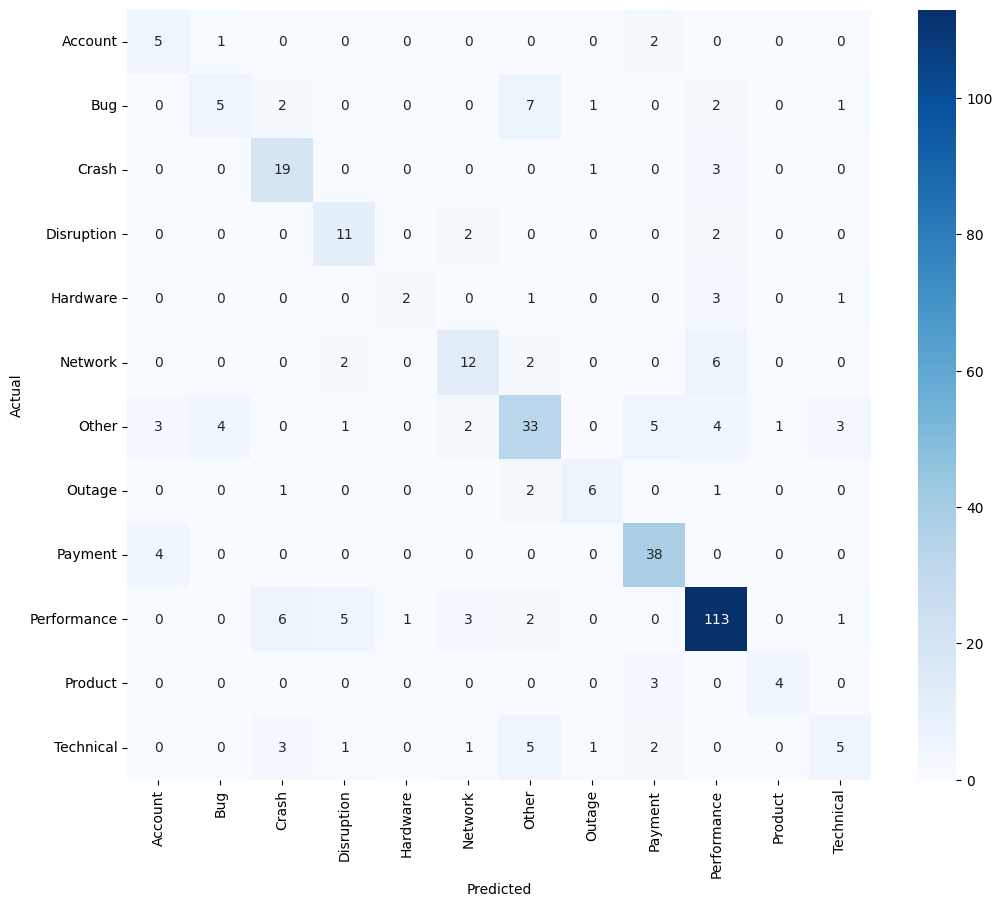

In [184]:
# Confusion matrix
cm = confusion_matrix(decoded_true, decoded_preds_l3)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_l3.classes_, yticklabels=le_l3.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
